In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from filter_data import *
from load_and_clean import *
import hdbscan
%matplotlib inline

In [23]:
import warnings
warnings.filterwarnings('ignore')

## Pre-processing data

In [24]:
#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

size=14
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
#plt.rcParams.update({'font.size': 14})

In [25]:
#Load and clean all raw data

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'North Macedonia', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Taiwan*', 'Syria', 'West Bank and Gaza', 'Saint Kitts and Nevis', 'Burma', 'MS Zaandam', 'Western Sahara']


In [26]:
#Filter data 
# This part might be to split and explain
# This part might be to split and explain
t = 7

global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1)  
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1) 
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted], axis = 1)
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted], axis = 1)
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

last date
Exceptions are []


In [11]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

In [42]:
counties_mandated = []
for state in masks_mandated:
    counties_mandated = counties_mandated+list(uscounties.loc[uscounties.state == state].county_state.unique())

counties_recommended = []
for state in masks_recommended:
    counties_recommended = counties_recommended + list(uscounties.loc[uscounties.state == state].county_state.unique())

df1 = df[df.columns[(df>100).any()]].copy()

counties_mandated = list(df1.columns[df1.columns.isin(counties_mandated)])
df1 = df[df.columns[(df>50).any()]].copy()

counties_recommended = list(df1.columns[df1.columns.isin(counties_recommended)])

## Counterfactual analysis based on mask mandates

Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties


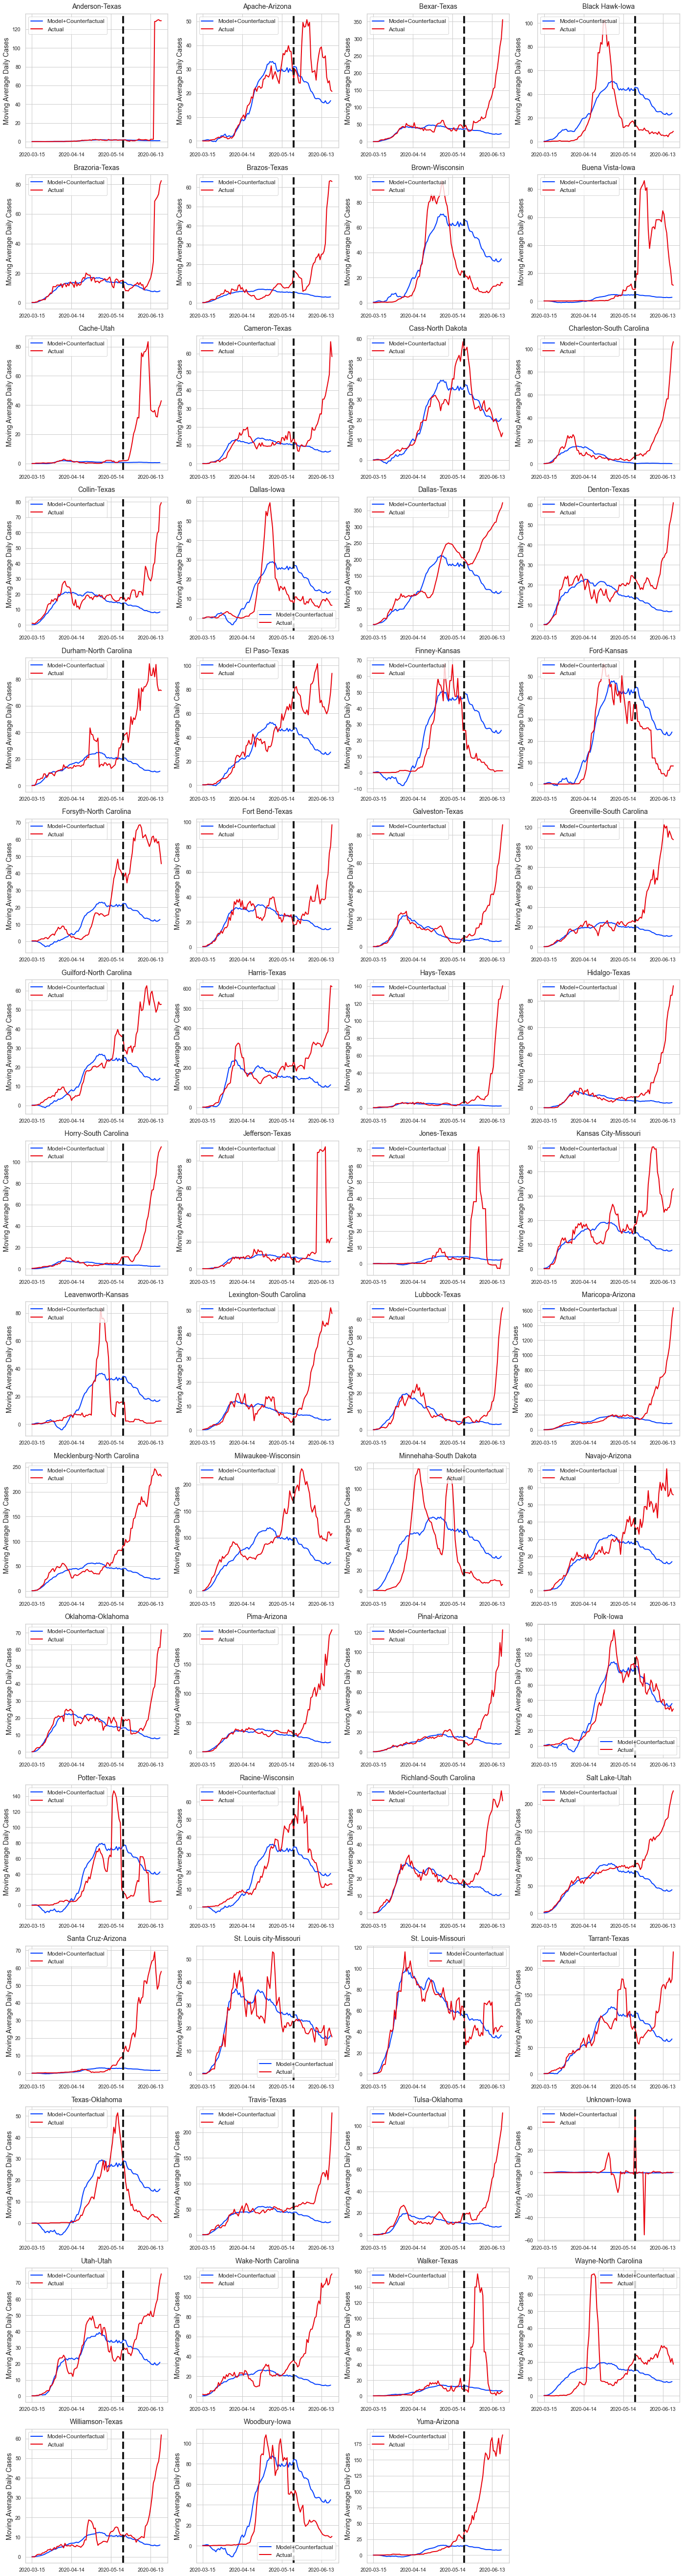

In [72]:
df = all_data_cases_daily.loc['2020-03-15':]
#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=30

#sizes = df.apply(pd.Series.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
high_thresh = df.shape[0]
low_thresh = high_thresh-30
targets = counties_recommended #counties_recommended #masks_mandated
otherStates = counties_mandated #masks_recommended
singVals=3
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*6.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

i=1
print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")
for state in targets:
    #otherStates =  counties_recommended.copy()
    #otherStates.remove(state)
    all_rows = list.copy(otherStates)
    all_rows.append(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state,fontsize=14, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    plt.savefig("../figures/"+state+".png")
    i=i+1
plt.show()


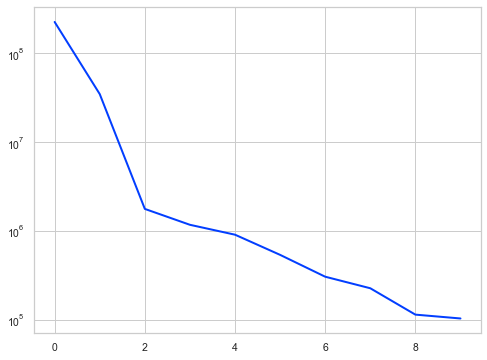

In [67]:
plt.rcParams['figure.figsize'] = (8, 6.0)
df = trainDF[otherStates]
(U, s, Vh) = np.linalg.svd((df) - np.mean(df))
s2 = np.power(s, 2) 
plt.yscale('log')
plt.plot(s2)

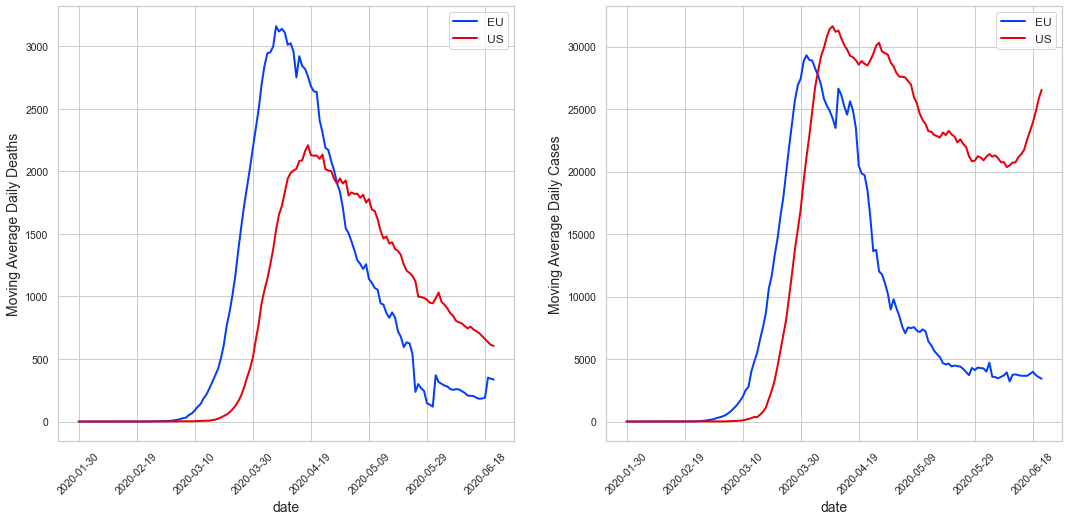

In [68]:
plt.rcParams['figure.figsize'] = (18, 8)

group_a = eu_countries
group_b = ['US']

group_a_label = "EU"
group_b_label = "US"

#group_a = masks_mandated
#group_b = masks_recommended

#group_a_label = 'Masks Mandated Everywhere'
#group_b_label = 'Masks Not Mandated Anywhere'

plt.subplot(1,2,1)
all_data_daily[group_a].sum(axis=1).plot(label=group_a_label), all_data_daily[group_b].sum(axis=1).plot(label=group_b_label), plt.legend(), plt.xticks(rotation=45), 
plt.ylabel('Moving Average Daily Deaths')
plt.subplot(1,2,2)
all_data_cases_daily[group_a].sum(axis=1).plot(label=group_a_label), all_data_cases_daily[group_b].sum(axis=1).plot(label=group_b_label), plt.legend(),
plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases')
plt.show()

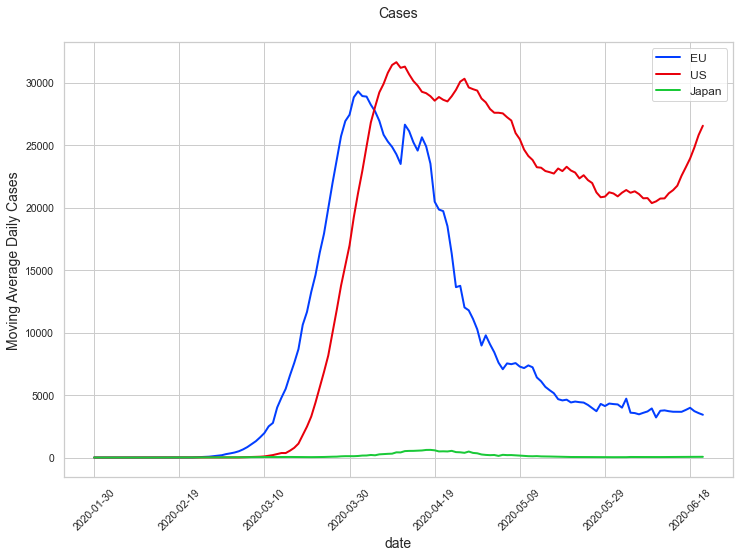

In [71]:
plt.rcParams['figure.figsize'] = (12, 8)
#group_a = ['Santa Clara-California']
#group_b = ['Los Angeles-California']
#group_a_label = 'Bay Area'
#group_b_label = 'Southern California'
all_data_cases_daily[group_a].sum(axis=1).plot(label=group_a_label), all_data_cases_daily[group_b].sum(axis=1).plot(label=group_b_label), 
all_data_cases_daily['Japan'].plot(), plt.legend(),
plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases')
plt.show()